In [78]:
import pandas as pd
import numpy as np

In [79]:
#IMPORT DATASET
dataset_dir = "dataset/ISEAR.csv"
df = pd.read_csv(dataset_dir, encoding='latin-1')

In [80]:
#CONSTANTS
max_embedding_length = 300 #MAX EMBEDDING DIMENSION
max_sequence_length = 400 #INPUT LENGTH

In [81]:
print(df['Emotion'].value_counts())


Emotion
anger      1096
sadness    1096
disgust    1096
shame      1096
fear       1095
joy        1094
guilt      1093
Name: count, dtype: int64


In [82]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [83]:
# Remove numbers
df['Text'] = df['Text'].apply(lambda x: re.sub('[0-9]+', '', x))

# Remove punctuations
df['Text'] = df['Text'].apply(lambda x: re.sub('[^\w\s]+', '', x))

# Convert to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stop_words]))

# Tokenize
df['Tokenized'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    lemmatized = [lemmatizer.lemmatize(token) for token in text]
    return lemmatized

df['Lemmatized'] = df['Tokenized'].apply(lemmatize)


detokenizer = TreebankWordDetokenizer()

df['Detokenized'] = df['Lemmatized'].apply(lambda x: detokenizer.detokenize(x))

In [84]:
df 

,Emotion,Text,Tokenized,Lemmatized,Detokenized
0,joy,period falling love time met especially met lo...,"[period, falling, love, time, met, especially,...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,involved traffic accident,"[involved, traffic, accident]","[involved, traffic, accident]",involved traffic accident
2,anger,driving home several days hard work motorist a...,"[driving, home, several, days, hard, work, mot...","[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,lost person meant,"[lost, person, meant]","[lost, person, meant]",lost person meant
4,disgust,time knocked deer sight animals injuries helpl...,"[time, knocked, deer, sight, animals, injuries...","[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...,...
7661,anger,two years back someone invited tutor granddaug...,"[two, years, back, someone, invited, tutor, gr...","[two, year, back, someone, invited, tutor, gra...",two year back someone invited tutor granddaugh...
7662,sadness,taken responsibility something prepared howeve...,"[taken, responsibility, something, prepared, h...","[taken, responsibility, something, prepared, h...",taken responsibility something prepared howeve...
7663,disgust,home heard loud sound spitting outside door th...,"[home, heard, loud, sound, spitting, outside, ...","[home, heard, loud, sound, spitting, outside, ...",home heard loud sound spitting outside door th...
7664,shame,homework teacher asked us scolded immediately,"[homework, teacher, asked, us, scolded, immedi...","[homework, teacher, asked, u, scolded, immedia...",homework teacher asked u scolded immediately


In [85]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [86]:
le = LabelEncoder()
y = le.fit_transform(df['Emotion'])

y = to_categorical(y)

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df['Detokenized'], y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [89]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

5366
1150
1150


In [90]:
def concatenate_text(data):
    return [''.join(text) for text in data]

text_arr = concatenate_text(df['Detokenized'])
text_train_arr = concatenate_text(X_train)
text_test_arr = concatenate_text(X_test)
text_val_arr = concatenate_text(X_val)

In [91]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [92]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_arr)

sequences_train = tokenizer.texts_to_sequences(text_train_arr)
sequences_test = tokenizer.texts_to_sequences(text_test_arr)
sequences_val = tokenizer.texts_to_sequences(text_val_arr)

In [93]:
X_train_padded = pad_sequences(sequences_train, maxlen = max_sequence_length )
X_test_padded = pad_sequences(sequences_test, maxlen = max_sequence_length )
X_val_padded = pad_sequences(sequences_val, maxlen = max_sequence_length )

In [94]:
from gensim.models import KeyedVectors

In [95]:
#EMBEDDING MATRIX CREATION -> CHOOSE ONE

#1ST CHOICE -> USING GLOVE OR FASTTEXT -> JUST CHANGE THE FILEPATH # wiki-news-300d-1M.vec # glove.6B.300d.txt
# embeddings = {}
# with open('embedding/wiki-news-300d-1M.vec', encoding='utf-8') as f:
#     for line in f:
#         token = line.split()[0]
#         embeddings[token] = np.array(line.split()[1:], dtype='float32')

#2ND CHOICE -> USING WORD2VEC
embeddings = KeyedVectors.load_word2vec_format('embedding/GoogleNews-vectors-negative300.bin', binary=True)

In [96]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, max_embedding_length))
for word, i in tokenizer.word_index.items():
    if i < len(tokenizer.word_index) + 1 and word in embeddings:
        embedding_matrix[i] = embeddings[word]

In [97]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07080078, -0.21386719,  0.15332031, ..., -0.21679688,
        -0.01977539,  0.10644531],
       [-0.06689453,  0.07958984, -0.08398438, ...,  0.02575684,
         0.31640625, -0.16796875],
       ...,
       [ 0.19042969,  0.30859375, -0.08496094, ...,  0.17578125,
        -0.09912109,  0.31054688],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0546875 ,  0.13769531,  0.29296875, ...,  0.16699219,
         0.10693359,  0.1953125 ]])

In [98]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import os

In [105]:
def test_model(type="LSTM"):
    model = Sequential()

    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=max_embedding_length, 
                        input_length = max_sequence_length, 
                        weights = [embedding_matrix], 
                        trainable=False))

    if (type == "LSTM"):
        model.add(LSTM(128, return_sequences = True))
    elif (type == "BiLSTM"):
        model.add(Bidirectional(LSTM(128, return_sequences = True)))
    else:
        model.add(GRU(128, return_sequences = True))

        
    model.add(GlobalMaxPool1D())
    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.summary()

    history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), epochs=10, batch_size= 128)

    output_dir = os.path.join('./output', type)

    #Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(type + ' Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    loss_filename = f"{type}_Model_Loss.png"
    loss_path = os.path.join(output_dir, loss_filename)
    plt.savefig(loss_path)
    plt.show()

    #Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(type + ' Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper right')
    accuracy_filename = f"{type}_Model_Accuracy.png"
    accuracy_path = os.path.join(output_dir, accuracy_filename)
    plt.savefig(accuracy_path)
    plt.show()

    prediction_results = model.predict(X_test_padded)
    prediction_results = np.argmax(prediction_results, axis=1)

    y_test_result = np.argmax(y_test, axis=1)

    test_accuracy = accuracy_score(y_test_result, prediction_results)
    test_recall = recall_score(y_test_result, prediction_results, average='weighted')
    test_precision = precision_score(y_test_result, prediction_results, average='weighted')
    test_f1 = f1_score(y_test_result, prediction_results, average='weighted')

    print(f"Accuracy: {test_accuracy:.3f}%")
    print(f"Recall Score: {test_recall:.3f}")
    print(f"Precision: {test_precision:.3f}")
    print(f"F1 Score: {test_f1:.3f}")

    results = {
        'Accuracy': test_accuracy,
        'Recall': test_recall,
        'Precision': test_precision,
        'F1 Score': test_f1
    }

    return results

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 lstm_14 (LSTM)              (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 7)                 903       
                                                                 
Total params: 2,702,451
Trainable params: 220,551
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
42/42 [==============================] - 6s 85ms/step - loss: 1.8038 - accuracy: 0.3494 - va

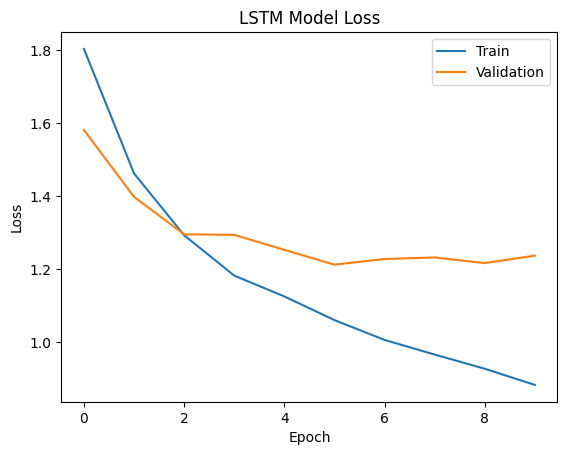

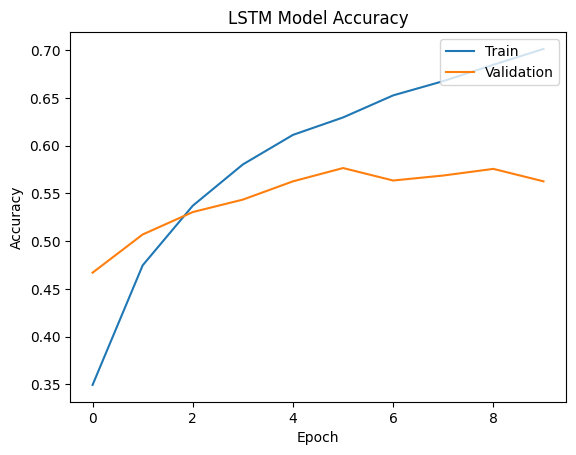

36/36 [==============================] - 1s 15ms/step
Accuracy: 0.577%
Recall Score: 0.577
Precision: 0.585
F1 Score: 0.571


In [106]:
result_lstm = test_model("LSTM")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 bidirectional_7 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_12 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_21 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 2,922,995
Trainable params: 441,095
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
42/42 [===================

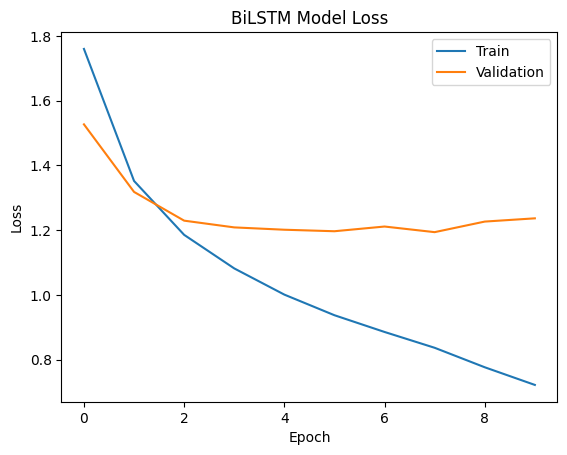

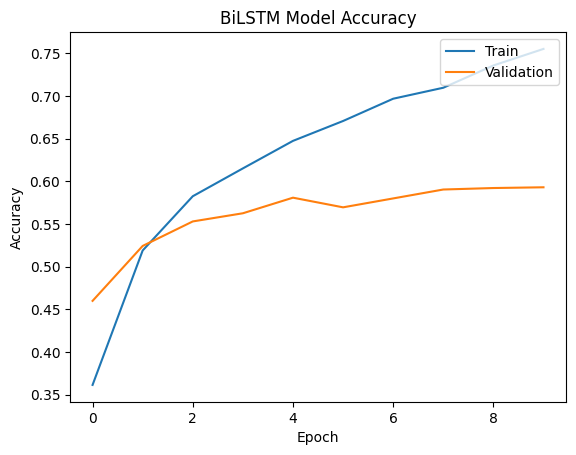

36/36 [==============================] - 2s 27ms/step
Accuracy: 0.593%
Recall Score: 0.593
Precision: 0.596
F1 Score: 0.590


In [107]:
result_bilstm = test_model("BiLSTM")

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 gru_6 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_13 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 7)                 903       
                                                                 
Total params: 2,647,923
Trainable params: 166,023
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
42/42 [==============================] - 5s 75ms/step - loss: 1.8089 - accuracy: 0.3664 - va

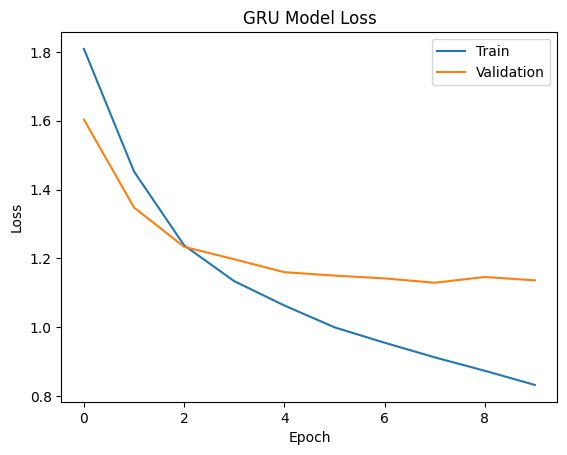

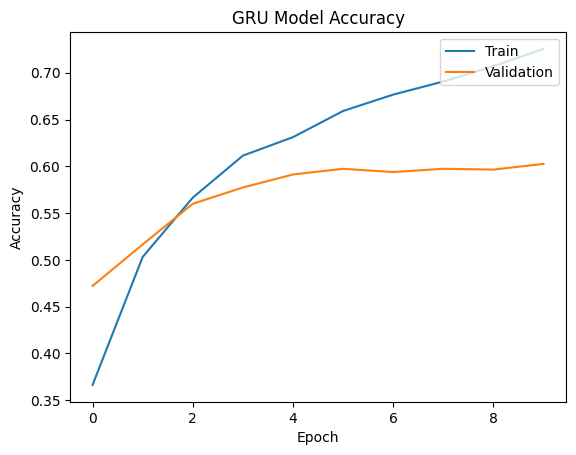

36/36 [==============================] - 1s 9ms/step
Accuracy: 0.603%
Recall Score: 0.603
Precision: 0.604
F1 Score: 0.599


In [108]:
result_gru = test_model("GRU")

In [109]:
import csv
from tabulate import tabulate

model_list = ["LSTM", "BiLSTM", "GRU"]
performance_list = ["Accuracy", "Recall", "Precision", "F1 Score"]
result_list = [result_lstm, result_bilstm, result_gru]

result = [["Model"] + performance_list]

for model_key, model in enumerate(model_list):
    row = [model]
    row.extend([round(result_list[model_key][metric], 4) for metric in performance_list])
    result.append(row)

table = tabulate(result, headers="firstrow", tablefmt="fancy_grid")

with open("./output/result.csv", "w") as file:
    writer = csv.writer(file)
    writer.writerows(result)

In [110]:
print("ISEAR: ")
print(table)

ISEAR: 
╒═════════╤════════════╤══════════╤═════════════╤════════════╕
│ Model   │   Accuracy │   Recall │   Precision │   F1 Score │
╞═════════╪════════════╪══════════╪═════════════╪════════════╡
│ LSTM    │     0.5765 │   0.5765 │      0.5845 │     0.5705 │
├─────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM  │     0.593  │   0.593  │      0.5955 │     0.59   │
├─────────┼────────────┼──────────┼─────────────┼────────────┤
│ GRU     │     0.6026 │   0.6026 │      0.6045 │     0.5987 │
╘═════════╧════════════╧══════════╧═════════════╧════════════╛
